# Statistical and Machine Learning Analysis

This notebook contains the final statistical and ML analysis investigating the relationship between the T-cell data and antibody response. 

In [1]:
# Imports & setup
import os

import numpy as np

import re

import pandas as pd
from pandas import read_csv

import matplotlib.pyplot as plt
CB_COLOR_CYCLE = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', 
                  '#e41a1c', '#dede00']

import scipy.stats as stats

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, SparsePCA
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score as nmi
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (balanced_accuracy_score, r2_score, confusion_matrix, recall_score, 
                             roc_auc_score, average_precision_score)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import plot_partial_dependence

import xgboost as xgb

import networkx as nx

from data_loader import construct_tcell_df, construct_mfi_df
from bootstrap_utils import (run_repeated_CV_XGB, boot_train_test_XGB, boot_train_test_LR, boot_train_test_random, 
                             boot_train_test_feature, boot_feature_selection, boot_feature_selection_LR, 
                             boot_train_test_XGB_trt_vs_ab)
from misc_utils import print_perf_statistics
from plotting_utils import parcoord_plot, plot_errorbars, parcoord_plot_sep, plotting_setup

In [2]:
# Some extra performance metrics
sensitivity = recall_score


def specificity(y_true, y_pred):
    return balanced_accuracy_score(y_true, y_pred) * 2 - recall_score(y_true, y_pred)

In [3]:
# Load raw data
# NB: low_memory=False is needed to deal with mixed type variables
df = read_csv(filepath_or_buffer="CoV-ETH_190721_to_JV_190721.csv", low_memory=False)

# Inclusion criteria: 
included = np.logical_or(df['Proband_in_miltenyi_positive_negative_consolidated'].values == 'positive', 
                        df['Proband_in_miltenyi_positive_negative_consolidated'].values == 'negative')
df_included = df.loc[np.squeeze(np.argwhere(included)),]

### Defining Consolidated Antibody Response

In [4]:
consolidated_response_S10 = np.logical_and(df_included['RB50_IgG_S10'].values >= 50, 
                        np.logical_or(df_included['NP50_IgG_S10'].values >= 5.0, 
                                      np.logical_or(df_included['S150_IgG_S10'].values >= 20, 
                                                    df_included['S250_IgG_S10'].values >= 5.0)))
consolidated_response_S11 = np.logical_and(df_included['RB50_IgG_S11'].values >= 50, 
                        np.logical_or(df_included['NP50_IgG_S11'].values >= 5.0, 
                                      np.logical_or(df_included['S150_IgG_S11'].values >= 20, 
                                                    df_included['S250_IgG_S11'].values >= 5.0)))
consolidated_response_ = np.logical_or(consolidated_response_S10, consolidated_response_S11)

# TODO: need to drop RBD-only patients, will do this after cleaning up csvs and excel sheets
RBn_only_S10 = np.logical_and(df_included['RB50_IgG_S10'].values >= 50, 
                        np.logical_not(np.logical_or(df_included['NP50_IgG_S10'].values >= 5.0, 
                                      np.logical_or(df_included['S150_IgG_S10'].values >=20, 
                                                    df_included['S250_IgG_S10'].values >= 5.0))))
RBn_only_S11 = np.logical_and(df_included['RB50_IgG_S11'].values >= 50, 
                        np.logical_not(np.logical_or(df_included['NP50_IgG_S11'].values >= 5.0, 
                                      np.logical_or(df_included['S150_IgG_S11'].values >= 20, 
                                                    df_included['S250_IgG_S11'].values >= 5.0))))
RBn_only = np.logical_and(RBn_only_S10, RBn_only_S11)

consolidated_response = np.copy(consolidated_response_).astype('U32')
consolidated_response[consolidated_response_] = 'positive'
consolidated_response[np.logical_not(consolidated_response_)] = 'negative'
consolidated_response[RBn_only] = 'borderline'

In [5]:
# Frequencies & percentages of different response categories
unique, counts = np.unique(consolidated_response[consolidated_response != 'borderline'], return_counts=True)
print(unique)
print(counts)
print(counts / np.sum(counts) * 100.0)

['negative' 'positive']
[69 65]
[51.49253731 48.50746269]


## Exploratory Analysis: Principal Component Analysis

In [6]:
# Percentage data
df_tcell_p, feature_names_p = construct_tcell_df(df_included, feature_type='perc', scale=True)

In [8]:
# Data point labels defined based on consolidated response
cls = np.copy(df_included['Proband_in_miltenyi_positive_negative_consolidated'].values)
cls[consolidated_response == 'positive'] = 'tab:orange'
cls[consolidated_response == 'negative'] = 'tab:blue'
cls[consolidated_response == 'borderline'] = 'tab:grey'

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


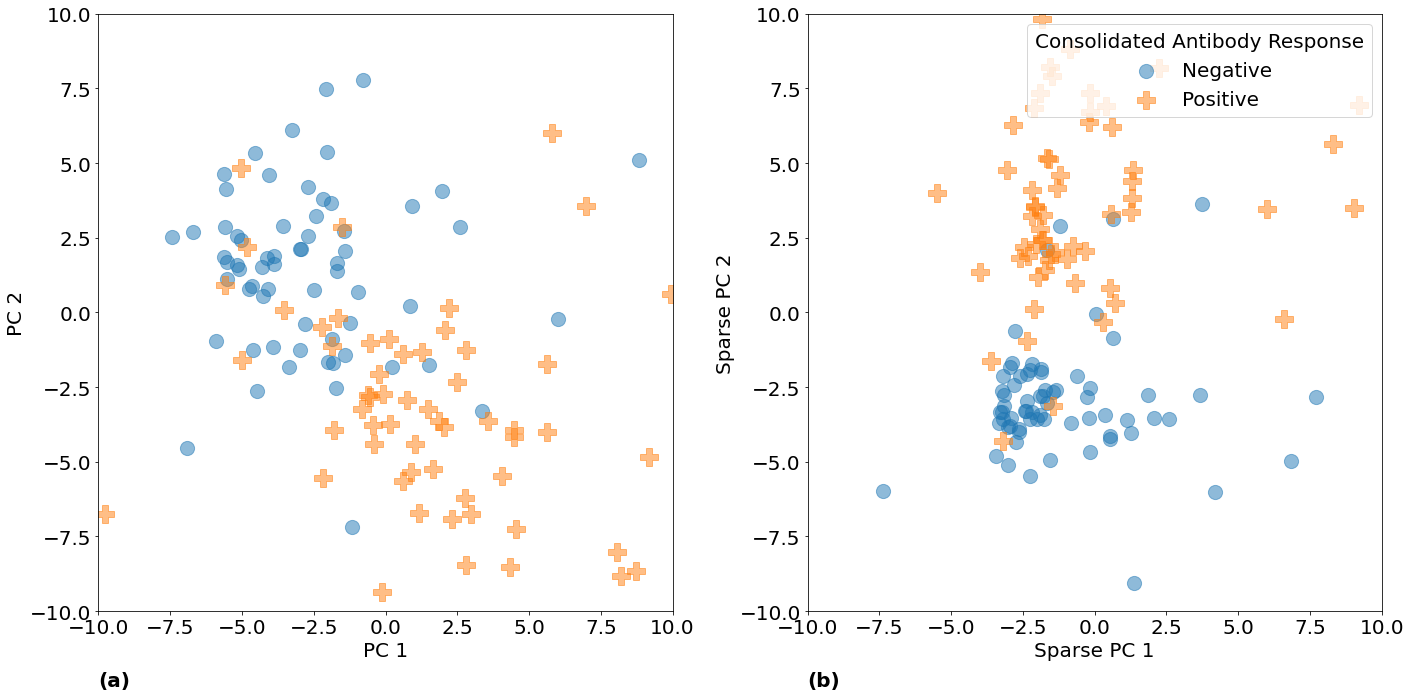

In [9]:
# PCA vs. consolidated response
plotting_setup(20)

xlim = [-10, 10]
ylim = [-10, 10]

pcs = PCA(n_components=2, random_state=42)
pca = pcs.fit_transform(df_tcell_p)


fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].scatter(pca[cls == 'tab:blue', 0], pca[cls == 'tab:blue', 1], c='tab:blue', s=200, 
            alpha=0.5, label='Negative', marker='o')
ax[0].scatter(pca[cls == 'tab:orange', 0], pca[cls == 'tab:orange', 1], c='tab:orange', s=300, 
            alpha=0.5, label='Positive', marker='P')

ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)
ax[0].set_xlabel("PC 1")
ax[0].set_ylabel("PC 2")

ax[0].text(xlim[0], ylim[0] - 2.5, '(a)', weight='bold')


# Sparse PCA vs. consolidated response
xlim = [-10, 10]
ylim = [-10, 10]

pcs = SparsePCA(n_components=2, random_state=42, alpha=5)
pca = pcs.fit_transform(df_tcell_p)

ax[1].scatter(pca[cls == 'tab:blue', 0], pca[cls == 'tab:blue', 1], c='tab:blue', s=200, 
            alpha=0.5, label='Negative', marker='o')
ax[1].scatter(pca[cls == 'tab:orange', 0], pca[cls == 'tab:orange', 1], c='tab:orange', s=300, 
            alpha=0.5, label='Positive', marker='P')

ax[1].legend(title='Consolidated Antibody Response', loc='upper right')
ax[1].set_xlim(xlim)
ax[1].set_ylim(ylim)
ax[1].set_xlabel("Sparse PC 1")
ax[1].set_ylabel("Sparse PC 2")

ax[1].text(xlim[0], ylim[0] - 2.5, '(b)', weight='bold')

plt.tight_layout()
plt.savefig(fname="figures/pca_combo.png", dpi=300)

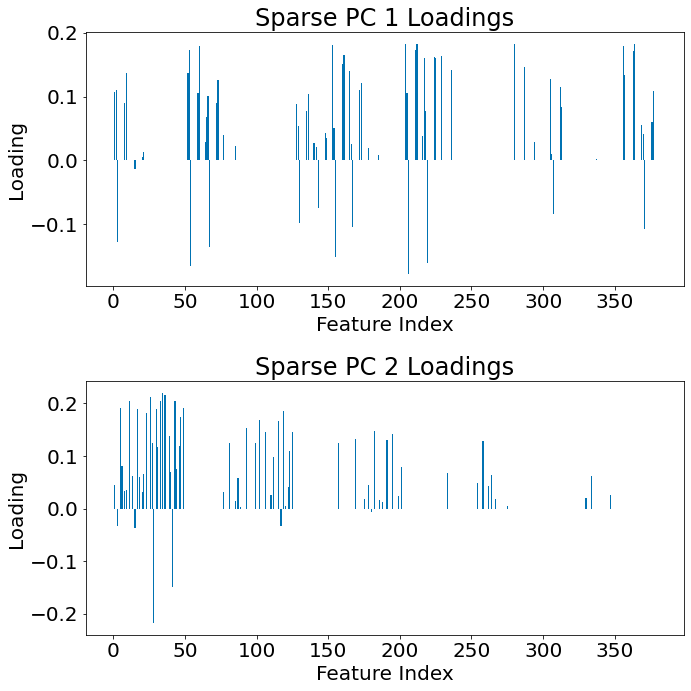

In [15]:
# Sparse PCA loadings

# Visualise sparse PC loadings
pc_loadings = pcs.components_.T

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].bar(x=np.arange(0, pc_loadings.shape[0]), height=pc_loadings[:, 0])
ax[0].set_title('Sparse PC 1 Loadings')
ax[0].set_xlabel('Feature Index')
ax[0].set_ylabel('Loading')

ax[1].bar(x=np.arange(0, pc_loadings.shape[0]), height=pc_loadings[:, 1])
ax[1].set_title('Sparse PC 2 Loadings')
ax[1].set_xlabel('Feature Index')
ax[1].set_ylabel('Loading')

plt.tight_layout()

In [18]:
# Important features in sparse PC 2
print(feature_names_p[np.abs(pc_loadings[:, 1]) > 0])

['CD3.IFN_pos_TNF_pos_perc_2_S10' 'CD3.IFN_neg_TNF_neg_perc_2_S10'
 'CD3.IL2_pos_CD154_pos_perc_2_S10' 'CD3.IL2_neg_CD154_pos_perc_2_S10'
 'CD3.IFN_pos_perc_2_S10' 'CD3.TNF_pos_perc_2_S10'
 'CD3.CD154_pos_perc_2_S10' 'CD3.IFN_pos_TNF_pos_perc_2_S11'
 'CD3.IFN_neg_TNF_neg_perc_2_S11' 'CD3.IL2_pos_CD154_pos_perc_2_S11'
 'CD3.IL2_neg_CD154_pos_perc_2_S11' 'CD3.IFN_pos_perc_2_S11'
 'CD3.TNF_pos_perc_2_S11' 'CD3.CD154_pos_perc_2_S11'
 'CD4.IFN_pos_TNF_pos_perc_2_S10' 'CD4.IFN_neg_TNF_pos_perc_2_S10'
 'CD4.IFN_neg_TNF_neg_perc_2_S10' 'CD4.IL2_pos_CD154_pos_perc_2_S10'
 'CD4.IL2_neg_CD154_pos_perc_2_S10' 'CD4.IFN_pos_perc_2_S10'
 'CD4.TNF_pos_perc_2_S10' 'CD4.CD154_pos_perc_2_S10'
 'CD4.IFN_pos_TNF_pos_perc_2_S11' 'CD4.IFN_neg_TNF_pos_perc_2_S11'
 'CD4.IFN_neg_TNF_neg_perc_2_S11' 'CD4.IL2_pos_CD154_pos_perc_2_S11'
 'CD4.IL2_neg_CD154_pos_perc_2_S11' 'CD4.IFN_pos_perc_2_S11'
 'CD4.TNF_pos_perc_2_S11' 'CD4.CD154_pos_perc_2_S11'
 'CD3.IFN_pos_TNF_pos_perc_3_S10' 'CD3.IFN_neg_TNF_neg_perc_3_S10'


## Predicting Antibody Response Using T-cell Measurements

   ### Counts

In [19]:
# Count data: logistic regression
if os.path.isfile('results/metrics_clf_counts_cons_lr.csv') and \
   os.path.isfile('results/metrics_proba_counts_cons_lr.csv') and \
   os.path.isfile('results/feat_imps_counts_cons_lr.csv'):
    metrics_clf_c_lr = np.loadtxt(fname="results/metrics_clf_counts_cons_lr.csv", delimiter=",")
    metrics_proba_c_lr = np.loadtxt(fname="results/metrics_proba_counts_cons_lr.csv", delimiter=",")
    feature_importances_c_lr = np.loadtxt(fname="results/feat_imps_counts_cons_lr.csv", delimiter=",")
else:
    df_tcell_c, feature_names_c = construct_tcell_df(df_included, feature_type='count')
    disease_status = consolidated_response
    disease_status = ((disease_status == 'positive') * 1.).astype(int)

    metrics_clf_c_lr, metrics_proba_c_lr, feature_importances_c_lr = boot_train_test_LR(
        X=df_tcell_c[np.logical_not(RBn_only), :], y=disease_status[np.logical_not(RBn_only)], 
        metrics_clf=[balanced_accuracy_score, sensitivity, specificity], 
        metrics_proba=[roc_auc_score, average_precision_score], B=1000)
    np.savetxt(fname="results/metrics_clf_counts_cons_lr.csv", X=metrics_clf_c_lr, delimiter=",")
    np.savetxt(fname="results/metrics_proba_counts_cons_lr.csv", X=metrics_proba_c_lr, delimiter=",")
    np.savetxt(fname="results/feat_imps_counts_cons_lr.csv", X=feature_importances_c_lr, delimiter=",")

In [20]:
print_perf_statistics(metrics_clf_c_lr, alpha=0.05)

0.835; [0.622, 1.0]
0.822; [0.454, 1.0]
0.849; [0.5, 1.0]


In [21]:
print_perf_statistics(metrics_proba_c_lr, alpha=0.05)

0.922; [0.733, 1.0]
0.93; [0.733, 1.0]


In [22]:
# Count data: XGBoost
if os.path.isfile('results/metrics_clf_counts_cons.csv') and \
   os.path.isfile('results/metrics_proba_counts_cons.csv') and \
   os.path.isfile('results/feat_imps_counts_cons.csv'):
    metrics_clf_c = np.loadtxt(fname="results/metrics_clf_counts_cons.csv", delimiter=",")
    metrics_proba_c = np.loadtxt(fname="results/metrics_proba_counts_cons.csv", delimiter=",")
    feature_importances_c = np.loadtxt(fname="results/feat_imps_counts_cons.csv", delimiter=",")
else:
    df_tcell_c, feature_names_c = construct_tcell_df(df_included, feature_type='count')
    disease_status = consolidated_response
    disease_status = ((disease_status == 'positive') * 1.).astype(int)

    metrics_clf_c, metrics_proba_c, feature_importances_c = boot_train_test_XGB(
        X=df_tcell_c, y=disease_status, metrics_clf=[balanced_accuracy_score, sensitivity, specificity], 
        metrics_proba=[roc_auc_score, average_precision_score], B=1000, borderline_cases=RBn_only, 
        drop_borderline=True)
    np.savetxt(fname="results/metrics_clf_counts_cons.csv", X=metrics_clf_c, delimiter=",")
    np.savetxt(fname="results/metrics_proba_counts_cons.csv", X=metrics_proba_c, delimiter=",")
    np.savetxt(fname="results/feat_imps_counts_cons.csv", X=feature_importances_c, delimiter=",")

In [23]:
print_perf_statistics(metrics_clf_c, alpha=0.05)

0.891; [0.69, 1.0]
0.887; [0.6, 1.0]
0.896; [0.538, 1.0]


In [24]:
print_perf_statistics(metrics_proba_c, alpha=0.05)

0.954; [0.795, 1.0]
0.965; [0.819, 1.0]


### Percentages

In [25]:
# Percentage data: logistic regression
if os.path.isfile('results/metrics_clf_percs_cons_lr.csv') and \
   os.path.isfile('results/metrics_proba_percs_cons_lr.csv') and \
   os.path.isfile('results/feat_imps_percs_cons_lr.csv'):
    metrics_clf_p_lr = np.loadtxt(fname="results/metrics_clf_percs_cons_lr.csv", delimiter=",")
    metrics_proba_p_lr = np.loadtxt(fname="results/metrics_proba_percs_cons_lr.csv", delimiter=",")
    feature_importances_p_lr = np.loadtxt(fname="results/feat_imps_percs_cons_lr.csv", delimiter=",")
else:
    df_tcell_p, feature_names_p = construct_tcell_df(df_included, feature_type='perc')
    disease_status = consolidated_response
    disease_status = ((disease_status == "positive") * 1.0).astype(int)

    metrics_clf_p_lr, metrics_proba_p_lr, feature_importances_p_lr = boot_train_test_LR(
        X=df_tcell_p[np.logical_not(RBn_only), :], y=disease_status[np.logical_not(RBn_only)], 
        metrics_clf=[balanced_accuracy_score, sensitivity, specificity], 
        metrics_proba=[roc_auc_score, average_precision_score], B=1000)
    np.savetxt(fname="results/metrics_clf_percs_cons_lr.csv", X=metrics_clf_p_lr, delimiter=",")
    np.savetxt(fname="results/metrics_proba_percs_cons_lr.csv", X=metrics_proba_p_lr, delimiter=",")
    np.savetxt(fname="results/feat_imps_percs_cons_lr.csv", X=feature_importances_p_lr, delimiter=",")

In [26]:
print_perf_statistics(metrics_clf_p_lr, alpha=0.05)

0.895; [0.712, 1.0]
0.891; [0.583, 1.0]
0.9; [0.636, 1.0]


In [27]:
print_perf_statistics(metrics_proba_p_lr, alpha=0.05)

0.953; [0.8, 1.0]
0.955; [0.782, 1.0]


In [28]:
# Percentage data: XGBoost
if os.path.isfile('results/metrics_clf_percs_cons.csv') and \
   os.path.isfile('results/metrics_proba_percs_cons.csv') and \
   os.path.isfile('results/feat_imps_percs_cons.csv'):
    metrics_clf_p = np.loadtxt(fname="results/metrics_clf_percs_cons.csv", delimiter=",")
    metrics_proba_p = np.loadtxt(fname="results/metrics_proba_percs_cons.csv", delimiter=",")
    feature_importances_p = np.loadtxt(fname="results/feat_imps_percs_cons.csv", delimiter=",")
else:
    df_tcell_p, feature_names_p = construct_tcell_df(df_included, feature_type='perc')
    disease_status = consolidated_response
    disease_status = ((disease_status == "positive") * 1.0).astype(int)

    metrics_clf_p, metrics_proba_p, feature_importances_p = boot_train_test_XGB(
        X=df_tcell_p, y=disease_status, metrics_clf=[balanced_accuracy_score, sensitivity, specificity], 
        metrics_proba=[roc_auc_score, average_precision_score], B=1000, verbose=True, 
        borderline_cases=RBn_only, drop_borderline=True)
    np.savetxt(fname="results/metrics_clf_percs_cons.csv", X=metrics_clf_p, delimiter=",")
    np.savetxt(fname="results/metrics_proba_percs_cons.csv", X=metrics_proba_p, delimiter=",")
    np.savetxt(fname="results/feat_imps_percs_cons.csv", X=feature_importances_p, delimiter=",")

In [29]:
print_perf_statistics(metrics_clf_p, alpha=0.05)

0.915; [0.744, 1.0]
0.906; [0.667, 1.0]
0.923; [0.666, 1.0]


In [30]:
print_perf_statistics(metrics_proba_p, alpha=0.05)

0.959; [0.796, 1.0]
0.959; [0.749, 1.0]


### Counts & Percentages

In [31]:
# Count + percentage data: logistic regression
if os.path.isfile('results/metrics_clf_pc_cons_lr.csv') and \
   os.path.isfile('results/metrics_proba_pc_cons_lr.csv') and \
   os.path.isfile('results/feat_imps_pc_cons_lr.csv'):
    metrics_clf_pc_lr = np.loadtxt(fname="results/metrics_clf_pc_cons_lr.csv", delimiter=",")
    metrics_proba_pc_lr = np.loadtxt(fname="results/metrics_proba_pc_cons_lr.csv", delimiter=",")
    feature_importances_pc_lr = np.loadtxt(fname="results/feat_imps_pc_cons_lr.csv", delimiter=",")
else:
    df_tcell_c, feature_names_c = construct_tcell_df(df_included, feature_type='count')
    df_tcell_p, feature_names_p = construct_tcell_df(df_included, feature_type='perc')
    df_tcell_pc = np.concatenate((df_tcell_p, df_tcell_c), axis=1)
    feature_names_pc = np.concatenate((feature_names_p, feature_names_c))
    disease_status = consolidated_response
    disease_status = ((disease_status == "positive") * 1.0).astype(int)

    metrics_clf_pc_lr, metrics_proba_pc_lr, feature_importances_pc_lr = boot_train_test_LR(
        X=df_tcell_pc[np.logical_not(RBn_only), :], y=disease_status[np.logical_not(RBn_only)], 
        metrics_clf=[balanced_accuracy_score, sensitivity, specificity], 
        metrics_proba=[roc_auc_score, average_precision_score], B=1000)
    np.savetxt(fname="results/metrics_clf_pc_cons_lr.csv", X=metrics_clf_pc_lr, delimiter=",")
    np.savetxt(fname="results/metrics_proba_pc_cons_lr.csv", X=metrics_proba_pc_lr, delimiter=",")
    np.savetxt(fname="results/feat_imps_pc_cons_lr.csv", X=feature_importances_pc_lr, delimiter=",")

In [32]:
print_perf_statistics(metrics_clf_pc_lr, alpha=0.05)

0.88; [0.693, 1.0]
0.852; [0.5, 1.0]
0.908; [0.65, 1.0]


In [33]:
print_perf_statistics(metrics_proba_pc_lr, alpha=0.05)

0.95; [0.806, 1.0]
0.954; [0.8, 1.0]


In [34]:
# Count + percentage data: XGBoost
if os.path.isfile('results/metrics_clf_pc_cons.csv') and \
   os.path.isfile('results/metrics_proba_pc_cons.csv') and \
   os.path.isfile('results/feat_imps_pc_cons.csv'):
    metrics_clf_pc = np.loadtxt(fname="results/metrics_clf_pc_cons.csv", delimiter=",")
    metrics_proba_pc = np.loadtxt(fname="results/metrics_proba_pc_cons.csv", delimiter=",")
    feature_importances_pc = np.loadtxt(fname="results/feat_imps_pc_cons.csv", delimiter=",")
else:
    df_tcell_c, feature_names_c = construct_tcell_df(df_included, feature_type='count')
    df_tcell_p, feature_names_p = construct_tcell_df(df_included, feature_type='perc')
    df_tcell_pc = np.concatenate((df_tcell_p, df_tcell_c), axis=1)
    feature_names_pc = np.concatenate((feature_names_p, feature_names_c))
    disease_status = consolidated_response
    disease_status = ((disease_status == "positive") * 1.0).astype(int)

    metrics_clf_pc, metrics_proba_pc, feature_importances_pc = boot_train_test_XGB(
        X=df_tcell_pc, y=disease_status, metrics_clf=[balanced_accuracy_score, sensitivity, specificity],
        metrics_proba=[roc_auc_score, average_precision_score], B=1000, 
        borderline_cases=RBn_only, drop_borderline=True)
    np.savetxt(fname="results/metrics_clf_pc_cons.csv", X=metrics_clf_pc, delimiter=",")
    np.savetxt(fname="results/metrics_proba_pc_cons.csv", X=metrics_proba_pc, delimiter=",")
    np.savetxt(fname="results/feat_imps_pc_cons.csv", X=feature_importances_pc, delimiter=",")

In [35]:
print_perf_statistics(metrics_clf_pc, alpha=0.05)

0.913; [0.723, 1.0]
0.902; [0.625, 1.0]
0.924; [0.636, 1.0]


In [36]:
print_perf_statistics(metrics_proba_pc, alpha=0.05)

0.961; [0.8, 1.0]
0.962; [0.765, 1.0]


### MFIs

In [37]:
# MFI data: LR
if os.path.isfile('results/metrics_clf_mfi_cons_lr.csv') and \
   os.path.isfile('results/metrics_proba_mfi_cons_lr.csv') and \
   os.path.isfile('results/feat_imps_mfi_cons_lr.csv'):
    metrics_clf_mfi_lr = np.loadtxt(fname="results/metrics_clf_mfi_cons_lr.csv", delimiter=",")
    metrics_proba_mfi_lr = np.loadtxt(fname="results/metrics_proba_mfi_cons_lr.csv", delimiter=",")
    feature_importances_mfi_lr = np.loadtxt(fname="results/feat_imps_mfi_cons_lr.csv", delimiter=",")
else:
    df_tcell_mfi, feature_names_mfi = construct_mfi_df(df_included)
    disease_status = consolidated_response
    disease_status = ((disease_status == "positive") * 1.0).astype(int)

    metrics_clf_mfi_lr, metrics_proba_mfi_lr, feature_importances_mfi_lr = boot_train_test_LR(
        X=df_tcell_mfi[np.logical_not(RBn_only), :], y=disease_status[np.logical_not(RBn_only)], 
        metrics_clf=[balanced_accuracy_score, sensitivity, specificity], 
        metrics_proba=[roc_auc_score, average_precision_score], B=1000)
    np.savetxt(fname="results/metrics_clf_mfi_cons_lr.csv", X=metrics_clf_mfi_lr, delimiter=",")
    np.savetxt(fname="results/metrics_proba_mfi_cons_lr.csv", X=metrics_proba_mfi_lr, delimiter=",")
    np.savetxt(fname="results/feat_imps_mfi_cons_lr.csv", X=feature_importances_mfi_lr, delimiter=",")

In [38]:
print_perf_statistics(metrics_clf_mfi_lr, alpha=0.05)

0.791; [0.558, 0.971]
0.775; [0.4, 1.0]
0.806; [0.444, 1.0]


In [39]:
print_perf_statistics(metrics_proba_mfi_lr, alpha=0.05)

0.874; [0.641, 1.0]
0.883; [0.601, 1.0]


In [40]:
# MFI data: XGBoost
if os.path.isfile('results/metrics_clf_mfi_cons.csv') and \
   os.path.isfile('results/metrics_proba_mfi_cons.csv') and \
   os.path.isfile('results/feat_imps_mfi_cons.csv'):
    metrics_clf_mfi = np.loadtxt(fname="results/metrics_clf_mfi_cons.csv", delimiter=",")
    metrics_proba_mfi = np.loadtxt(fname="results/metrics_proba_mfi_cons.csv", delimiter=",")
    feature_importances_mfi = np.loadtxt(fname="results/feat_imps_mfi_cons.csv", delimiter=",")
else:
    df_tcell_mfi, feature_names_mfi = construct_mfi_df(df_included)
    disease_status = consolidated_response
    disease_status = ((disease_status == "positive") * 1.0).astype(int)

    metrics_clf_mfi, metrics_proba_mfi, feature_importances_mfi = boot_train_test_XGB(
        X=df_tcell_mfi, y=disease_status, metrics_clf=[balanced_accuracy_score, sensitivity, specificity], 
        metrics_proba=[roc_auc_score, average_precision_score], B=1000, 
        borderline_cases=RBn_only, drop_borderline=True)
    np.savetxt(fname="results/metrics_clf_mfi_cons.csv", X=metrics_clf_mfi, delimiter=",")
    np.savetxt(fname="results/metrics_proba_mfi_cons.csv", X=metrics_proba_mfi, delimiter=",")
    np.savetxt(fname="results/feat_imps_mfi_cons.csv", X=feature_importances_mfi, delimiter=",")

In [41]:
print_perf_statistics(metrics_clf_mfi, alpha=0.05)

0.858; [0.639, 1.0]
0.851; [0.533, 1.0]
0.865; [0.5, 1.0]


In [42]:
print_perf_statistics(metrics_proba_mfi, alpha=0.05)

0.926; [0.731, 1.0]
0.926; [0.681, 1.0]


### Random Guess

In [43]:
# Random guess

if os.path.isfile('results/metrics_clf_cons_rand.csv') and os.path.isfile('results/metrics_proba_cons_rand.csv'):
    metrics_clf_r = np.loadtxt(fname="results/metrics_clf_cons_rand.csv", delimiter=",")
    metrics_proba_r = np.loadtxt(fname="results/metrics_proba_cons_rand.csv", delimiter=",")
else:
    df_tcell_p, feature_names_p = construct_tcell_df(df_included, feature_type='perc')
    disease_status = consolidated_response
    disease_status = ((disease_status == "positive") * 1.0).astype(int)
    metrics_clf_r, metrics_proba_r = boot_train_test_random(X=df_tcell_p[np.logical_not(RBn_only), :], 
                                                            y=disease_status[np.logical_not(RBn_only)], 
                                                            metrics_clf=[balanced_accuracy_score, sensitivity, 
                                                                         specificity], 
                                                            metrics_proba=[roc_auc_score, 
                                                                           average_precision_score], 
                                                            B=10000)
    np.savetxt(fname="results/metrics_clf_cons_rand.csv", X=metrics_clf_r, delimiter=",")
    np.savetxt(fname="results/metrics_proba_cons_rand.csv", X=metrics_proba_r, delimiter=",")

In [44]:
print_perf_statistics(metrics_clf_r, alpha=0.05)

0.501; [0.328, 0.677]
0.397; [0.0, 0.682]
0.605; [0.3, 0.833]


In [45]:
print_perf_statistics(metrics_proba_r, alpha=0.05)

0.501; [0.328, 0.677]
0.409; [0.187, 0.652]


## Examining Important Variables

In [46]:
# Plotting setup
plt.rcParams.update({'font.size': 10})

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


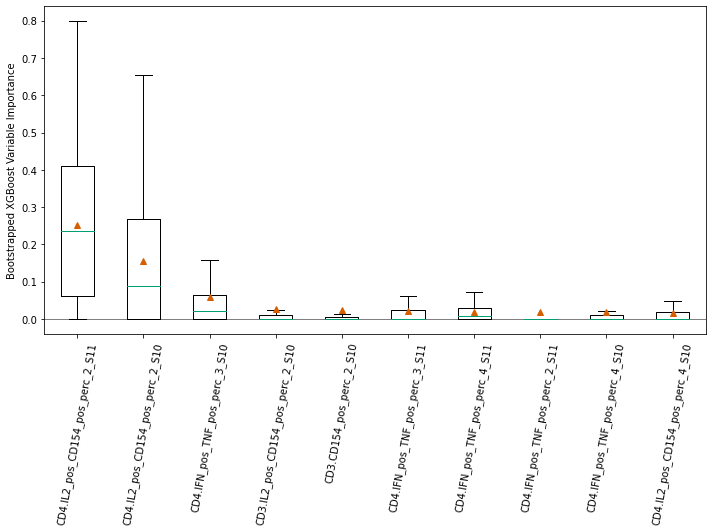

In [47]:
# Top 10 most important features among percentages in the GBM model
df_tcell_c, feature_names_c = construct_tcell_df(df_included, feature_type='count')
df_tcell_p, feature_names_p = construct_tcell_df(df_included, feature_type='perc', scale=True)
mean_feature_importances_p = np.mean(feature_importances_p, axis=0)
feature_importance_sd_p = np.std(feature_importances_p, axis=1)
top_10_features_p = feature_names_p[mean_feature_importances_p.argsort()[-10:][::-1]]
top_10_importances_p = feature_importances_p[:, mean_feature_importances_p.argsort()[-10:][::-1]]
fig = plt.figure(figsize=(10,7.5))
ax = plt.gca()
g0 = ax.axhline(c='grey', lw=1)
bx = plt.boxplot(top_10_importances_p, positions=np.arange(0, 10), showmeans=True, showfliers=False,
                labels=top_10_features_p)
xt = plt.xticks(rotation=80)
ylab = plt.ylabel("Bootstrapped XGBoost Variable Importance")
plt.tight_layout()
plt.savefig(fname="figures/xgb_varimp_percs_cons.png", dpi=300)

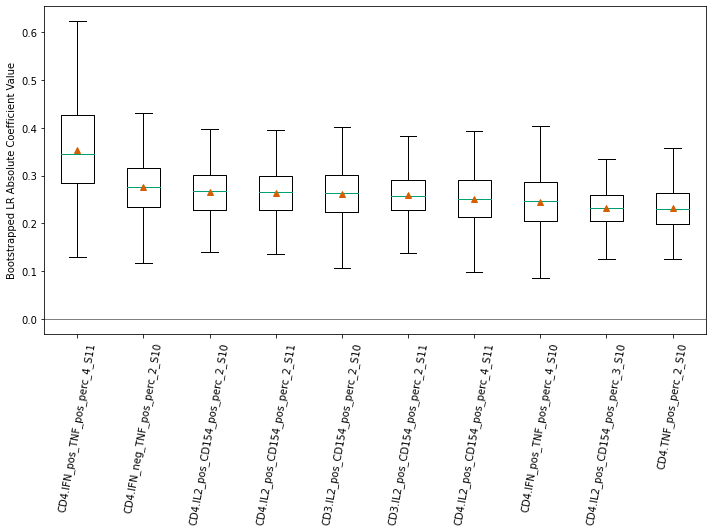

In [48]:
# Top 10 most important features among percentages in the LR model
mean_feature_importances_p_lr = np.mean(feature_importances_p_lr, axis=0)
feature_importance_sd_p_lr = np.std(feature_importances_p_lr, axis=1)
top_10_features_p_lr = feature_names_p[mean_feature_importances_p_lr.argsort()[-10:][::-1]]
top_10_importances_p_lr = feature_importances_p_lr[:, mean_feature_importances_p_lr.argsort()[-10:][::-1]]
fig = plt.figure(figsize=(10,7.5))
ax = plt.gca()
g0 = ax.axhline(c='grey', lw=1)
bx = plt.boxplot(top_10_importances_p_lr, positions=np.arange(0, 10), showmeans=True, showfliers=False,
                labels=top_10_features_p_lr)
xt = plt.xticks(rotation=80)
ylab = plt.ylabel("Bootstrapped LR Absolute Coefficient Value")
plt.tight_layout()
plt.savefig(fname="figures/lr_varimp_percs_cons.png", dpi=300)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


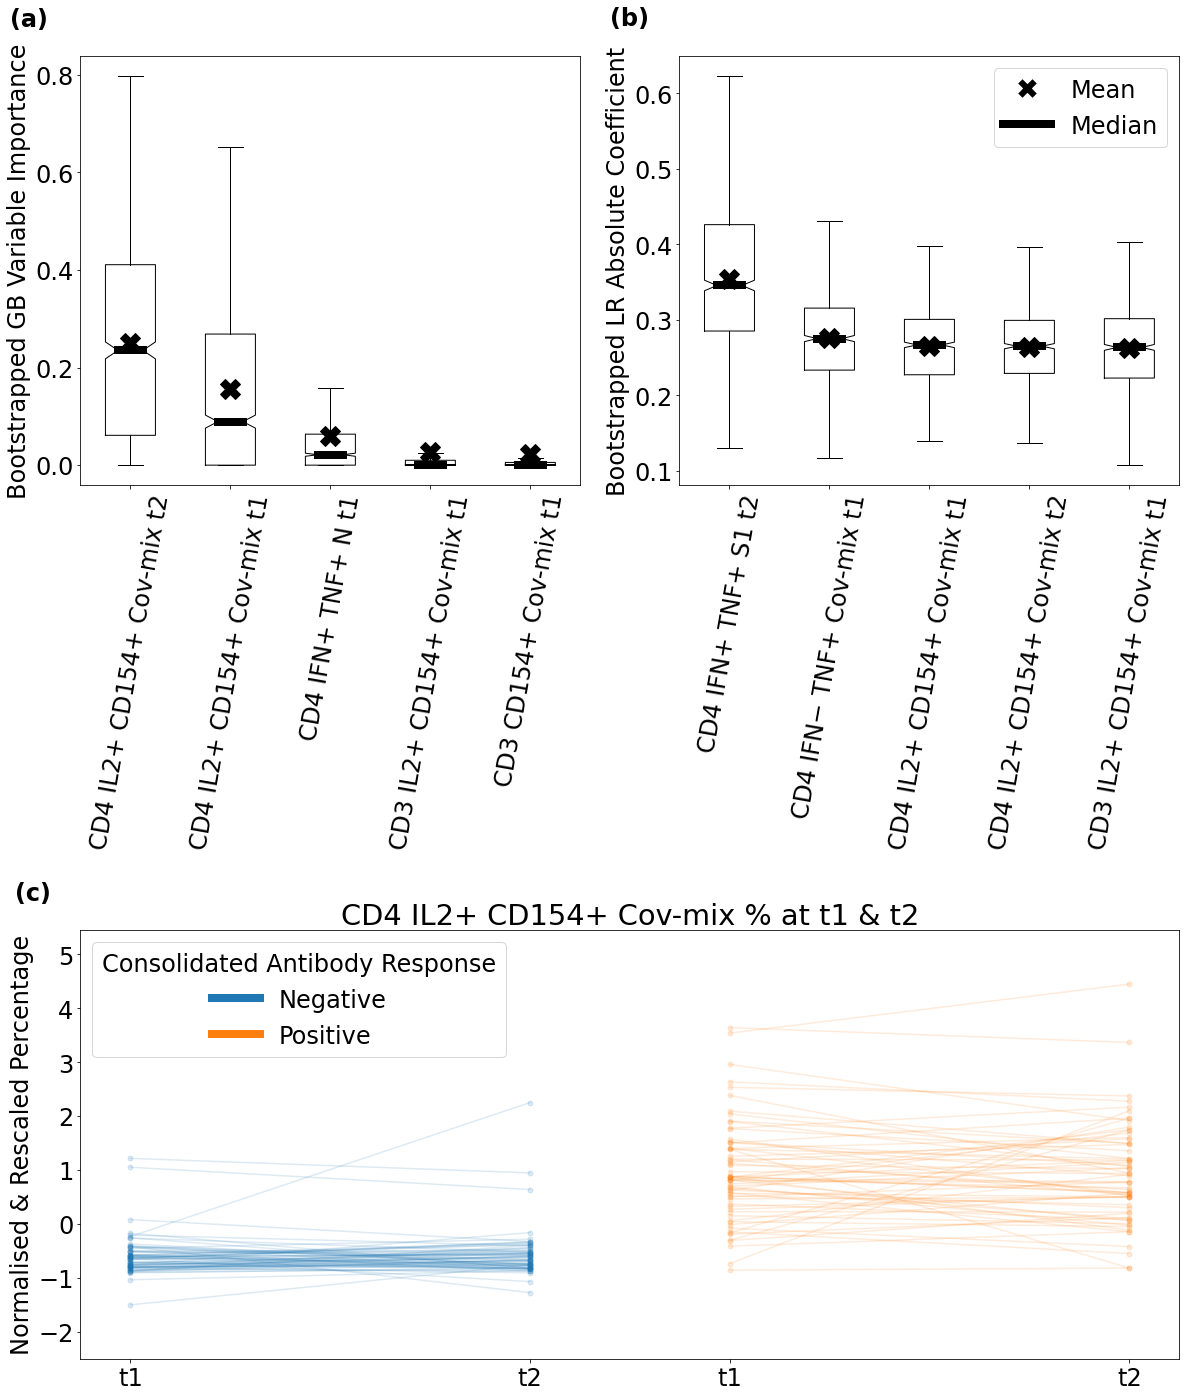

In [49]:
# Importance plot for the final paper
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

plotting_setup(24)


# Custom grid layout
plt.figure(figsize=(17, 20))
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,1,2)
ax = [ax1, ax2, ax3]


# XGBoost importances
mean_feature_importances_p = np.mean(feature_importances_p, axis=0)
feature_importance_sd_p = np.std(feature_importances_p, axis=1)
top_features_p = feature_names_p[mean_feature_importances_p.argsort()[-5:][::-1]]
top_importances_p = feature_importances_p[:, mean_feature_importances_p.argsort()[-5:][::-1]]

top_features_p = [s.replace('.', ' ').replace('_S10', ' t1').replace('_S11', ' t2').replace(
    '_perc', '').replace('_pos_', '+ ').replace(' 2 ', ' Cov-mix ').replace(
    ' 3 ', ' N ') for s in top_features_p]

flierprops = dict(marker='o', markerfacecolor='green', markersize=12,
                  markeredgecolor='none')
medianprops = dict(linestyle='-', linewidth=8, color='black')
meanpointprops = dict(marker='X', markeredgecolor='black',
                      markerfacecolor='black', markersize=20)

bx = ax[0].boxplot(top_importances_p, positions=np.arange(0, 5), showmeans=True, showfliers=False,
                   labels=top_features_p, notch=True, flierprops=flierprops, medianprops=medianprops, 
                   meanprops=meanpointprops)
ylab = ax[0].set_ylabel("Bootstrapped GB Variable Importance")
ax[0].tick_params(axis='x', rotation=80)


# Legend
legend_elements = [Line2D([0], [0], marker='X', color='white', label='Mean', 
                          markerfacecolor='black', markersize=20), 
                   Line2D([0], [0], color='black', lw=8, label='Median')]
ax[1].legend(loc='upper right', handles=legend_elements)


# LR importances
mean_feature_importances_p_lr = np.mean(feature_importances_p_lr, axis=0)
feature_importance_sd_p_lr = np.std(feature_importances_p_lr, axis=1)
top_features_p_lr = feature_names_p[mean_feature_importances_p_lr.argsort()[-5:][::-1]]
top_importances_p_lr = feature_importances_p_lr[:, mean_feature_importances_p_lr.argsort()[-5:][::-1]]

top_features_p_lr = [s.replace('.', ' ').replace('_S10', ' t1').replace('_S11', ' t2').replace(
    '_perc', '').replace('_pos_', '+ ').replace('_neg_', '− ').replace(
    ' 2 ', ' Cov-mix ').replace(' 3 ', ' N ').replace(' 4 ', ' S1 ') for s in top_features_p_lr]

bx = ax[1].boxplot(top_importances_p_lr, positions=np.arange(0, 5), showmeans=True, showfliers=False, 
                   labels=top_features_p_lr, notch=True, flierprops=flierprops, medianprops=medianprops, 
                   meanprops=meanpointprops)
ylab = ax[1].set_ylabel("Bootstrapped LR Absolute Coefficient")
ax[1].tick_params(axis='x', rotation=80)


# Parallel coordinate plot for CD4 IL2+ CD154+ Cov-mix
cls = np.copy(consolidated_response)
borderline_cases = RBn_only
cls = cls[np.logical_not(borderline_cases)]
cls[cls == 'positive'] = 'tab:orange'
cls[cls == 'negative'] = 'tab:blue'

x1=df_tcell_p[:, mean_feature_importances_p.argsort()[-10:][::-1]][:, 1]
x1=x1[np.logical_not(borderline_cases)]
x2=df_tcell_p[:, mean_feature_importances_p.argsort()[-10:][::-1]][:, 0]
x2=x2[np.logical_not(borderline_cases)]
tick1='t1' 
tick2='t2'
colors=cls
labels={'tab:blue': 'Negative', 'tab:orange': 'Positive'} 

cnt = 1
ticks_x = []
for c in np.unique(colors):
    label_c = labels[c]
    x1_c = x1[colors == c]
    x2_c = x2[colors == c]
    ax[2].scatter(np.ones_like(x1_c) * cnt, x1_c, c=c, label=label_c, s=25, alpha=0.15)
    ax[2].scatter(np.ones_like(x2_c) * (cnt + 1), x2_c, c=c, s=25, alpha=0.15)
    for i in range(len(x1_c)):
        ax[2].plot([cnt, cnt + 1], [x1_c[i], x2_c[i]], c=c, alpha=0.15)
    ticks_x.append(cnt)
    ticks_x.append(cnt + 1)
    cnt = cnt + 1.5
ax[2].set_ylim([min(np.min(x1), np.min(x2)) - 1, max(np.max(x1), np.max(x2)) + 1])
ax[2].set_xticks(ticks=ticks_x)
ax[2].set_xticklabels(labels=[tick1, tick2] * len(np.unique(colors)))
ax[2].set_ylabel("Normalised & Rescaled Percentage")
legend_elements = [Line2D([0], [0], color='tab:blue', lw=8, label='Negative'),
                  Line2D([0], [0], color='tab:orange', lw=8, label='Positive')]
ax[2].legend(loc='upper left', handles=legend_elements, title='Consolidated Antibody Response')
ax[2].set_title('CD4 IL2+ CD154+ Cov-mix % at t1 & t2')

ax[0].text(-1.2, 0.9, '(a)', weight='bold')
ax[1].text(-1.2, 0.69, '(b)', weight='bold')
ax[2].text(0.71, 6, '(c)', weight='bold')

plt.tight_layout()


plt.savefig(fname="figures/xgb_varimp_cons.png", dpi=300, bbox_inches='tight')

## Comparing T-cell Types

### CD3

In [50]:
if os.path.isfile('results/metrics_clf_cons_cd3.csv') and \
   os.path.isfile('results/metrics_proba_cons_cd3.csv') and \
   os.path.isfile('results/feat_imps_cons_cd3.csv'):
    metrics_clf_cd3 = np.loadtxt(fname="results/metrics_clf_cons_cd3.csv", delimiter=",")
    metrics_proba_cd3 = np.loadtxt(fname="results/metrics_proba_cons_cd3.csv", delimiter=",")
    feature_importances_cd3 = np.loadtxt(fname="results/feat_imps_cons_cd3.csv", delimiter=",")
else:
    df_tcell_cd3, feature_names_cd3 = construct_tcell_df(df_included, feature_type='perc', tcell_types=['CD3'])
    disease_status = consolidated_response
    disease_status = ((disease_status == "positive") * 1.0).astype(int)

    metrics_clf_cd3, metrics_proba_cd3, feature_importances_cd3 = boot_train_test_XGB(
        X=df_tcell_cd3, y=disease_status, metrics_clf=[balanced_accuracy_score, sensitivity, specificity],
        metrics_proba=[roc_auc_score, average_precision_score], B=1000, borderline_cases=RBn_only, 
        drop_borderline=True)
    np.savetxt(fname="results/metrics_clf_cons_cd3.csv", X=metrics_clf_cd3, delimiter=",")
    np.savetxt(fname="results/metrics_proba_cons_cd3.csv", X=metrics_proba_cd3, delimiter=",")
    np.savetxt(fname="results/feat_imps_cons_cd3.csv", X=feature_importances_cd3, delimiter=",")

In [51]:
print_perf_statistics(metrics_clf_cd3, alpha=0.05)

0.895; [0.697, 1.0]
0.889; [0.583, 1.0]
0.901; [0.608, 1.0]


In [52]:
print_perf_statistics(metrics_proba_cd3, alpha=0.05)

0.948; [0.758, 1.0]
0.948; [0.732, 1.0]


### CD4

In [53]:
if os.path.isfile('results/metrics_clf_cons_cd4.csv') and \
   os.path.isfile('results/metrics_proba_cons_cd4.csv') and \
   os.path.isfile('results/feat_imps_cons_cd4.csv'):
    metrics_clf_cd4 = np.loadtxt(fname="results/metrics_clf_cons_cd4.csv", delimiter=",")
    metrics_proba_cd4 = np.loadtxt(fname="results/metrics_proba_cons_cd4.csv", delimiter=",")
    feature_importances_cd4 = np.loadtxt(fname="results/feat_imps_cons_cd4.csv", delimiter=",")
else:
    df_tcell_cd4, feature_names_cd4 = construct_tcell_df(df_included, feature_type='perc', tcell_types=['CD4'])
    disease_status = consolidated_response
    disease_status = ((disease_status == "positive") * 1.0).astype(int)

    metrics_clf_cd4, metrics_proba_cd4, feature_importances_cd4 = boot_train_test_XGB(
        X=df_tcell_cd4, y=disease_status, metrics_clf=[balanced_accuracy_score, sensitivity, specificity],
        metrics_proba=[roc_auc_score, average_precision_score], B=1000, borderline_cases=RBn_only,
        drop_borderline=True)
    np.savetxt(fname="results/metrics_clf_cons_cd4.csv", X=metrics_clf_cd4, delimiter=",")
    np.savetxt(fname="results/metrics_proba_cons_cd4.csv", X=metrics_proba_cd4, delimiter=",")
    np.savetxt(fname="results/feat_imps_cons_cd4.csv", X=feature_importances_cd4, delimiter=",")

In [54]:
print_perf_statistics(metrics_clf_cd4, alpha=0.05)

0.916; [0.742, 1.0]
0.908; [0.666, 1.0]
0.925; [0.643, 1.0]


In [55]:
print_perf_statistics(metrics_proba_cd4, alpha=0.05)

0.962; [0.814, 1.0]
0.962; [0.784, 1.0]


### CD8

In [56]:
if os.path.isfile('results/metrics_clf_cons_cd8.csv') and \
   os.path.isfile('results/metrics_proba_cons_cd8.csv') and \
   os.path.isfile('results/feat_imps_cons_cd8.csv'):
    metrics_clf_cd8 = np.loadtxt(fname="results/metrics_clf_cons_cd8.csv", delimiter=",")
    metrics_proba_cd8 = np.loadtxt(fname="results/metrics_proba_cons_cd8.csv", delimiter=",")
    feature_importances_cd8 = np.loadtxt(fname="results/feat_imps_cons_cd8.csv", delimiter=",")
else:
    df_tcell_cd8, feature_names_cd8 = construct_tcell_df(df_included, feature_type='perc', tcell_types=['CD8'])
    disease_status = consolidated_response
    disease_status = ((disease_status == "positive") * 1.0).astype(int)

    metrics_clf_cd8, metrics_proba_cd8, feature_importances_cd8 = boot_train_test_XGB(
        X=df_tcell_cd8, y=disease_status, metrics_clf=[balanced_accuracy_score, sensitivity, specificity],
        metrics_proba=[roc_auc_score, average_precision_score], B=1000, borderline_cases=RBn_only, 
        drop_borderline=True)
    np.savetxt(fname="results/metrics_clf_cons_cd8.csv", X=metrics_clf_cd8, delimiter=",")
    np.savetxt(fname="results/metrics_proba_cons_cd8.csv", X=metrics_proba_cd8, delimiter=",")
    np.savetxt(fname="results/feat_imps_cons_cd8.csv", X=feature_importances_cd8, delimiter=",")

In [57]:
print_perf_statistics(metrics_clf_cd8, alpha=0.05)

0.521; [0.25, 0.784]
0.511; [0.111, 0.917]
0.53; [0.133, 0.917]


In [58]:
print_perf_statistics(metrics_proba_cd8, alpha=0.05)

0.523; [0.219, 0.85]
0.584; [0.271, 0.886]


## Predicting Different Antibody Type Responses

In [63]:
# Consolidated
for trt in range(2, 7):
    boot_train_test_XGB_trt_vs_ab(trt=trt, ab='cons')
boot_train_test_XGB_trt_vs_ab(trt=-1, ab='cons')

In [64]:
# RB50
for trt in range(2, 7):
    boot_train_test_XGB_trt_vs_ab(trt=trt, ab='rb50')
boot_train_test_XGB_trt_vs_ab(trt=-1, ab='rb50')

In [66]:
# NP50
for trt in range(2, 7):
    boot_train_test_XGB_trt_vs_ab(trt=trt, ab='np50')
boot_train_test_XGB_trt_vs_ab(trt=-1, ab='np50')

In [67]:
# S150
for trt in range(2, 7):
    boot_train_test_XGB_trt_vs_ab(trt=trt, ab='s150')
boot_train_test_XGB_trt_vs_ab(trt=-1, ab='s150')

In [68]:
# S250
for trt in range(2, 7):
    boot_train_test_XGB_trt_vs_ab(trt=trt, ab='s250')
boot_train_test_XGB_trt_vs_ab(trt=-1, ab='s250')

In [69]:
# nAB
for trt in range(2, 7):
    boot_train_test_XGB_trt_vs_ab(trt=trt, ab='nab')
boot_train_test_XGB_trt_vs_ab(trt=-1, ab='nab')

### Visualising Results

In [70]:
# Load precomputed metrics
# RB50
metrics_proba_cov2mix_rb50 = np.loadtxt(fname="results/metrics_proba_rb50_cov2mix.csv", delimiter=",")
metrics_proba_n_rb50 = np.loadtxt(fname="results/metrics_proba_rb50_protn.csv", delimiter=",")
metrics_proba_s1_rb50 = np.loadtxt(fname="results/metrics_proba_rb50_prots1.csv", delimiter=",")
metrics_proba_s_rb50 = np.loadtxt(fname="results/metrics_proba_rb50_prots.csv", delimiter=",")
metrics_proba_m_rb50 = np.loadtxt(fname="results/metrics_proba_rb50_protm.csv", delimiter=",")
metrics_proba_r_rb50 = np.loadtxt(fname="results/metrics_proba_rb50_rand.csv", delimiter=",")
# NP50
metrics_proba_cov2mix_np50 = np.loadtxt(fname="results/metrics_proba_np50_cov2mix.csv", delimiter=",")
metrics_proba_n_np50 = np.loadtxt(fname="results/metrics_proba_np50_protn.csv", delimiter=",")
metrics_proba_s1_np50 = np.loadtxt(fname="results/metrics_proba_np50_prots1.csv", delimiter=",")
metrics_proba_s_np50 = np.loadtxt(fname="results/metrics_proba_np50_prots.csv", delimiter=",")
metrics_proba_m_np50 = np.loadtxt(fname="results/metrics_proba_np50_protm.csv", delimiter=",")
metrics_proba_r_np50 = np.loadtxt(fname="results/metrics_proba_np50_rand.csv", delimiter=",")
# S150
metrics_proba_cov2mix_s150 = np.loadtxt(fname="results/metrics_proba_s150_cov2mix.csv", delimiter=",")
metrics_proba_n_s150 = np.loadtxt(fname="results/metrics_proba_s150_protn.csv", delimiter=",")
metrics_proba_s1_s150 = np.loadtxt(fname="results/metrics_proba_s150_prots1.csv", delimiter=",")
metrics_proba_s_s150 = np.loadtxt(fname="results/metrics_proba_s150_prots.csv", delimiter=",")
metrics_proba_m_s150 = np.loadtxt(fname="results/metrics_proba_s150_protm.csv", delimiter=",")
metrics_proba_r_s150 = np.loadtxt(fname="results/metrics_proba_s150_rand.csv", delimiter=",")
# S250
metrics_proba_cov2mix_s250 = np.loadtxt(fname="results/metrics_proba_s250_cov2mix.csv", delimiter=",")
metrics_proba_n_s250 = np.loadtxt(fname="results/metrics_proba_s250_protn.csv", delimiter=",")
metrics_proba_s1_s250 = np.loadtxt(fname="results/metrics_proba_s250_prots1.csv", delimiter=",")
metrics_proba_s_s250 = np.loadtxt(fname="results/metrics_proba_s250_prots.csv", delimiter=",")
metrics_proba_m_s250 = np.loadtxt(fname="results/metrics_proba_s250_protm.csv", delimiter=",")
metrics_proba_r_s250 = np.loadtxt(fname="results/metrics_proba_s250_rand.csv", delimiter=",")
# nAB
metrics_proba_cov2mix_nab = np.loadtxt(fname="results/metrics_proba_nab_cov2mix.csv", delimiter=",")
metrics_proba_n_nab = np.loadtxt(fname="results/metrics_proba_nab_protn.csv", delimiter=",")
metrics_proba_s1_nab = np.loadtxt(fname="results/metrics_proba_nab_prots1.csv", delimiter=",")
metrics_proba_s_nab = np.loadtxt(fname="results/metrics_proba_nab_prots.csv", delimiter=",")
metrics_proba_m_nab = np.loadtxt(fname="results/metrics_proba_nab_protm.csv", delimiter=",")
metrics_proba_r_nab = np.loadtxt(fname="results/metrics_proba_nab_rand.csv", delimiter=",")
# Consolidated
metrics_proba_cov2mix_cons = np.loadtxt(fname="results/metrics_proba_cons_cov2mix.csv", delimiter=",")
metrics_proba_n_cons = np.loadtxt(fname="results/metrics_proba_cons_protn.csv", delimiter=",")
metrics_proba_s1_cons = np.loadtxt(fname="results/metrics_proba_cons_prots1.csv", delimiter=",")
metrics_proba_s_cons = np.loadtxt(fname="results/metrics_proba_cons_prots.csv", delimiter=",")
metrics_proba_m_cons = np.loadtxt(fname="results/metrics_proba_cons_protm.csv", delimiter=",")
metrics_proba_r_cons = np.loadtxt(fname="results/metrics_proba_cons_rand.csv", delimiter=",")

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


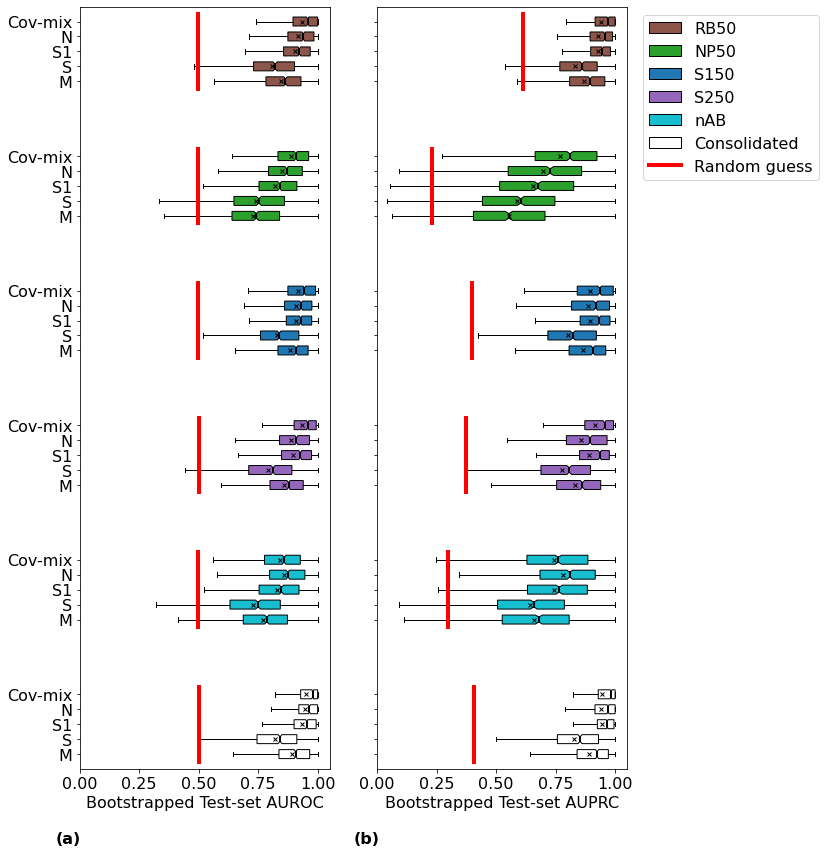

In [71]:
from matplotlib.lines import Line2D

np.random.seed(42)

# Load precomputed AUROCs
aurocs_rb50 = np.stack((metrics_proba_cov2mix_rb50[:, 0], metrics_proba_n_rb50[:, 0], metrics_proba_s1_rb50[:, 0], 
                       metrics_proba_s_rb50[:, 0], metrics_proba_m_rb50[:, 0]), axis=1)

aurocs_np50 = np.stack((metrics_proba_cov2mix_np50[:, 0], metrics_proba_n_np50[:, 0], metrics_proba_s1_np50[:, 0], 
                       metrics_proba_s_np50[:, 0], metrics_proba_m_np50[:, 0]), axis=1)
aurocs_np50_replace = np.tile(np.nanmean(aurocs_np50, axis=0), reps=(aurocs_np50.shape[0], 1))
aurocs_np50[np.isnan(aurocs_np50)] = aurocs_np50_replace[np.isnan(aurocs_np50)]

aurocs_s150 = np.stack((metrics_proba_cov2mix_s150[:, 0], metrics_proba_n_s150[:, 0], metrics_proba_s1_s150[:, 0], 
                       metrics_proba_s_s150[:, 0], metrics_proba_m_s150[:, 0]), axis=1)

aurocs_s250 = np.stack((metrics_proba_cov2mix_s250[:, 0], metrics_proba_n_s250[:, 0], metrics_proba_s1_s250[:, 0], 
                       metrics_proba_s_s250[:, 0], metrics_proba_m_s250[:, 0]), axis=1)

aurocs_nab = np.stack((metrics_proba_cov2mix_nab[:, 0], metrics_proba_n_nab[:, 0], metrics_proba_s1_nab[:, 0], 
                       metrics_proba_s_nab[:, 0], metrics_proba_m_nab[:, 0]), axis=1)
aurocs_nab_replace = np.tile(np.nanmean(aurocs_nab, axis=0), reps=(aurocs_nab.shape[0], 1))
aurocs_nab[np.isnan(aurocs_nab)] = aurocs_nab_replace[np.isnan(aurocs_nab)]

aurocs_cons = np.stack((metrics_proba_cov2mix_cons[:, 0], metrics_proba_n_cons[:, 0], metrics_proba_s1_cons[:, 0], 
                       metrics_proba_s_cons[:, 0], metrics_proba_m_cons[:, 0]), axis=1)


# Load precomputed AUPRCs
auprcs_rb50 = np.stack((metrics_proba_cov2mix_rb50[:, 1], metrics_proba_n_rb50[:, 1], metrics_proba_s1_rb50[:, 1], 
                       metrics_proba_s_rb50[:, 1], metrics_proba_m_rb50[:, 1]), axis=1)

auprcs_np50 = np.stack((metrics_proba_cov2mix_np50[:, 1], metrics_proba_n_np50[:, 1], metrics_proba_s1_np50[:, 1], 
                       metrics_proba_s_np50[:, 1], metrics_proba_m_np50[:, 1]), axis=1)
auprcs_np50_replace = np.tile(np.nanmean(auprcs_np50, axis=0), reps=(auprcs_np50.shape[0], 1))
auprcs_np50[np.isnan(auprcs_np50)] = auprcs_np50_replace[np.isnan(auprcs_np50)]

auprcs_s150 = np.stack((metrics_proba_cov2mix_s150[:, 1], metrics_proba_n_s150[:, 1], metrics_proba_s1_s150[:, 1], 
                       metrics_proba_s_s150[:, 1], metrics_proba_m_s150[:, 1]), axis=1)

auprcs_s250 = np.stack((metrics_proba_cov2mix_s250[:, 1], metrics_proba_n_s250[:, 1], metrics_proba_s1_s250[:, 1], 
                       metrics_proba_s_s250[:, 1], metrics_proba_m_s250[:, 1]), axis=1)

auprcs_nab = np.stack((metrics_proba_cov2mix_nab[:, 1], metrics_proba_n_nab[:, 1], metrics_proba_s1_nab[:, 1], 
                       metrics_proba_s_nab[:, 1], metrics_proba_m_nab[:, 1]), axis=1)
auprcs_nab_replace = np.tile(np.nanmean(auprcs_nab, axis=0), reps=(auprcs_nab.shape[0], 1))
auprcs_nab[np.isnan(auprcs_nab)] = auprcs_nab_replace[np.isnan(auprcs_nab)]

auprcs_cons = np.stack((metrics_proba_cov2mix_cons[:, 1], metrics_proba_n_cons[:, 1], metrics_proba_s1_cons[:, 1], 
                       metrics_proba_s_cons[:, 1], metrics_proba_m_cons[:, 1]), axis=1)

# Plotting setup
plotting_setup(16)
fig, ax = plt.subplots(1, 2, figsize=(12.5, 12))
medianprops = dict(linestyle='-', linewidth=2, color='black')
meanpointprops = dict(marker='x', markeredgecolor='black', markerfacecolor='black', markersize=4)


# Plot AUROCs
bx_rb50 = ax[0].boxplot(aurocs_rb50, positions=[-4.5, -5.0, -5.5, -6.0, -6.5], showfliers=False, 
                      labels=['Cov-mix', 'N', 'S1', 'S', 'M'], notch=True, patch_artist=True, vert=False, 
                      showmeans=True, medianprops=medianprops, meanprops=meanpointprops) 
colors = ['tab:brown' for i in range(7)]
for patch, color in zip(bx_rb50['boxes'], colors):
    patch.set_facecolor(color)
ax[0].plot([np.nanmean(metrics_proba_r_rb50[:, 0]), np.nanmean(metrics_proba_r_rb50[:, 0])], [-6.75, -4.25], 
         c='red', linewidth=4)


bx_np50 = ax[0].boxplot(aurocs_np50, positions=[-9.0, -9.5, -10.0, -10.5, -11.0], showfliers=False, 
                      labels=['Cov-mix', 'N', 'S1', 'S', 'M'], notch=True, patch_artist=True, vert=False,
                      showmeans=True, medianprops=medianprops, meanprops=meanpointprops) 
colors = ['tab:green' for i in range(7)]
for patch, color in zip(bx_np50['boxes'], colors):
    patch.set_facecolor(color)
ax[0].plot([np.nanmean(metrics_proba_r_np50[:, 0]), np.nanmean(metrics_proba_r_np50[:, 0])], [-8.75, -11.25], 
         c='red', linewidth=4)
    
bx_s150 = ax[0].boxplot(aurocs_s150, positions=[-13.5, -14.0, -14.5, -15.0, -15.5], showfliers=False, 
                      labels=['Cov-mix', 'N', 'S1', 'S', 'M'], notch=True, patch_artist=True, vert=False,
                      showmeans=True, medianprops=medianprops, meanprops=meanpointprops) 
colors = ['tab:blue' for i in range(7)]
for patch, color in zip(bx_s150['boxes'], colors):
    patch.set_facecolor(color)
ax[0].plot([np.nanmean(metrics_proba_r_s150[:, 0]), np.nanmean(metrics_proba_r_s150[:, 0])], [-13.25, -15.75], 
         c='red', linewidth=4)
    
bx_s250 = ax[0].boxplot(aurocs_s250, positions=[-18.0, -18.5, -19.0, -19.5, -20.0], showfliers=False, 
                      labels=['Cov-mix', 'N', 'S1', 'S', 'M'], notch=True, patch_artist=True, vert=False, 
                      showmeans=True, medianprops=medianprops, meanprops=meanpointprops) 
colors = ['tab:purple' for i in range(7)]
for patch, color in zip(bx_s250['boxes'], colors):
    patch.set_facecolor(color)
ax[0].plot([np.nanmean(metrics_proba_r_s250[:, 0]), np.nanmean(metrics_proba_r_s250[:, 0])], [-17.75, -20.25], 
         c='red', linewidth=4)
    
bx_nab = ax[0].boxplot(aurocs_nab, positions=[-22.5, -23.0, -23.5, -24.0, -24.5], showfliers=False, 
                     labels=['Cov-mix', 'N', 'S1', 'S', 'M'], notch=True, patch_artist=True, vert=False,
                     showmeans=True, medianprops=medianprops, meanprops=meanpointprops) 
colors = ['tab:cyan' for i in range(7)]
for patch, color in zip(bx_nab['boxes'], colors):
    patch.set_facecolor(color)
ax[0].plot([np.nanmean(metrics_proba_r_nab[:, 0]), np.nanmean(metrics_proba_r_nab[:, 0])], [-22.25, -24.75], 
         c='red', linewidth=4)
    
bx_cons = ax[0].boxplot(aurocs_cons, positions=[-27.0, -27.5, -28.0, -28.5, -29.0], showfliers=False, 
                      labels=['Cov-mix', 'N', 'S1', 'S', 'M'], notch=True, patch_artist=True, vert=False, 
                      showmeans=True, medianprops=medianprops, meanprops=meanpointprops) 
colors = ['white' for i in range(7)]
for patch, color in zip(bx_cons['boxes'], colors):
    patch.set_facecolor(color)
ax[0].plot([np.nanmean(metrics_proba_r_cons[:, 0]), np.nanmean(metrics_proba_r_cons[:, 0])], [-26.75, -29.25], 
         c='red', linewidth=4)
    
ax[0].set_xlabel('Bootstrapped Test-set AUROC')

ax[0].set_xlim([0, 1.05])

ax[0].text(-0.1, -32, '(a)', weight='bold')


# Plot AUPRCs
bx_rb50 = ax[1].boxplot(auprcs_rb50, positions=[-4.5, -5.0, -5.5, -6.0, -6.5], showfliers=False, 
                      labels=['', '', '', '', ''], notch=True, patch_artist=True, vert=False, 
                      showmeans=True, medianprops=medianprops, meanprops=meanpointprops) 
colors = ['tab:brown' for i in range(7)]
for patch, color in zip(bx_rb50['boxes'], colors):
    patch.set_facecolor(color)
ax[1].plot([np.nanmean(metrics_proba_r_rb50[:, 1]), np.nanmean(metrics_proba_r_rb50[:, 1])], [-6.75, -4.25], 
         c='red', linewidth=4)


bx_np50 = ax[1].boxplot(auprcs_np50, positions=[-9.0, -9.5, -10.0, -10.5, -11.0], showfliers=False, 
                      labels=['', '', '', '', ''], notch=True, patch_artist=True, vert=False,
                      showmeans=True, medianprops=medianprops, meanprops=meanpointprops) 
colors = ['tab:green' for i in range(7)]
for patch, color in zip(bx_np50['boxes'], colors):
    patch.set_facecolor(color)
ax[1].plot([np.nanmean(metrics_proba_r_np50[:, 1]), np.nanmean(metrics_proba_r_np50[:, 1])], [-8.75, -11.25], 
         c='red', linewidth=4)
    
bx_s150 = ax[1].boxplot(auprcs_s150, positions=[-13.5, -14.0, -14.5, -15.0, -15.5], showfliers=False, 
                      labels=['', '', '', '', ''], notch=True, patch_artist=True, vert=False,
                      showmeans=True, medianprops=medianprops, meanprops=meanpointprops) 
colors = ['tab:blue' for i in range(7)]
for patch, color in zip(bx_s150['boxes'], colors):
    patch.set_facecolor(color)
ax[1].plot([np.nanmean(metrics_proba_r_s150[:, 1]), np.nanmean(metrics_proba_r_s150[:, 1])], [-13.25, -15.75], 
         c='red', linewidth=4)
    
bx_s250 = ax[1].boxplot(auprcs_s250, positions=[-18.0, -18.5, -19.0, -19.5, -20.0], showfliers=False, 
                      labels=['', '', '', '', ''], notch=True, patch_artist=True, vert=False, 
                      showmeans=True, medianprops=medianprops, meanprops=meanpointprops) 
colors = ['tab:purple' for i in range(7)]
for patch, color in zip(bx_s250['boxes'], colors):
    patch.set_facecolor(color)
ax[1].plot([np.nanmean(metrics_proba_r_s250[:, 1]), np.nanmean(metrics_proba_r_s250[:, 1])], [-17.75, -20.25], 
         c='red', linewidth=4)
    
bx_nab = ax[1].boxplot(auprcs_nab, positions=[-22.5, -23.0, -23.5, -24.0, -24.5], showfliers=False, 
                     labels=['', '', '', '', ''], notch=True, patch_artist=True, vert=False,
                     showmeans=True, medianprops=medianprops, meanprops=meanpointprops) 
colors = ['tab:cyan' for i in range(7)]
for patch, color in zip(bx_nab['boxes'], colors):
    patch.set_facecolor(color)
ax[1].plot([np.nanmean(metrics_proba_r_nab[:, 1]), np.nanmean(metrics_proba_r_nab[:, 1])], [-22.25, -24.75], 
         c='red', linewidth=4)
    
bx_cons = ax[1].boxplot(auprcs_cons, positions=[-27.0, -27.5, -28.0, -28.5, -29.0], showfliers=False, 
                      labels=['', '', '', '', ''], notch=True, patch_artist=True, vert=False, 
                      showmeans=True, medianprops=medianprops, meanprops=meanpointprops) 
colors = ['white' for i in range(7)]
for patch, color in zip(bx_cons['boxes'], colors):
    patch.set_facecolor(color)
ax[1].plot([np.nanmean(metrics_proba_r_cons[:, 1]), np.nanmean(metrics_proba_r_cons[:, 1])], [-26.75, -29.25], 
         c='red', linewidth=4)
    
ax[1].legend([bx_rb50["boxes"][0], bx_np50["boxes"][0], bx_s150["boxes"][0], bx_s250["boxes"][0],
           bx_nab["boxes"][0], bx_cons["boxes"][0], Line2D([0], [0], color='red', lw=4)], 
           ['RB50', 'NP50', 'S150', 'S250', 'nAB', 'Consolidated', 'Random guess'], 
           loc='upper right',  bbox_to_anchor=(1.8, 1))
    
ax[1].set_xlabel('Bootstrapped Test-set AUPRC')

ax[1].set_xlim([0, 1.05])

ax[1].text(-0.1, -32, '(b)', weight='bold')


plt.tight_layout()

plt.savefig(fname="figures/antibody_boxplots.png", dpi=300, bbox_inches='tight')

## Assessing Associations between T-cell Data and Symptoms Score

In [72]:
# Data
rdata = df_included.values
rdata_cols = list(df_included.columns)
ndata, ndata_cols = construct_tcell_df(df_included, feature_type='', scale=False)
ndata_mfi, ndata_mfi_cols = construct_mfi_df(df_included, scale=False)

In [73]:
# Consolidated symptoms score
symptoms_score_S10 = np.squeeze(
    rdata[:, np.argwhere(np.array(rdata_cols) == 'symptoms_score_S10')[0]].astype(np.float64))
symptoms_score_S10[np.isnan(symptoms_score_S10)] = 0
symptoms_score_S11 = np.squeeze(
    rdata[:, np.argwhere(np.array(rdata_cols) == 'symptoms_score_S11')[0]].astype(np.float64))
symptoms_score_S11[np.isnan(symptoms_score_S11)] = 0
symptoms_score_consolidated = np.maximum(symptoms_score_S10, symptoms_score_S11)

In [74]:
# Some important features
CD4_IL2_CD154_S10 = np.squeeze(
    ndata[:, np.argwhere(ndata_cols == 'CD4.IL2_pos_CD154_pos_perc_2_S10')[0]].astype(np.float64))
CD4_IL2_CD154_S11 = np.squeeze(
    ndata[:, np.argwhere(ndata_cols == 'CD4.IL2_pos_CD154_pos_perc_2_S11')[0]].astype(np.float64))
CD4_IFN_TNF_S10 = np.squeeze(
    ndata[:, np.argwhere(ndata_cols == 'CD4.IFN_pos_TNF_pos_perc_3_S10')[0]].astype(np.float64))
CD4_IFN_TNF_S11 = np.squeeze(
    ndata[:, np.argwhere(ndata_cols == 'CD4.IFN_pos_TNF_pos_perc_3_S11')[0]].astype(np.float64))

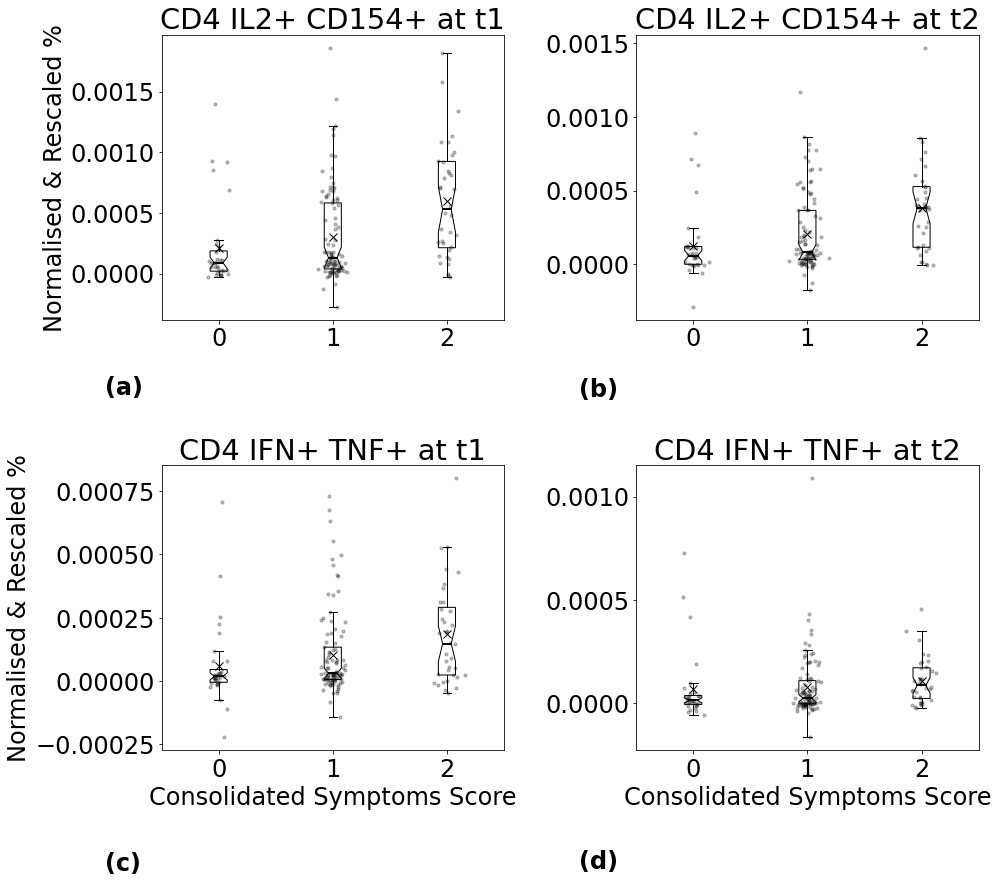

In [75]:
# Percentages vs. symptoms scores
np.random.seed(42)

plotting_setup(24)
fig, ax = plt.subplots(2, 2, figsize=(14, 13))
medianprops = dict(linestyle='-', linewidth=2, color='black')
meanpointprops = dict(marker='x', markeredgecolor='black', markerfacecolor='black', markersize=8)


scores = np.unique(symptoms_score_consolidated)
cnt = 0
for s in scores:
    bx_s = ax[0, 0].boxplot(CD4_IL2_CD154_S10[symptoms_score_consolidated == s], positions=[cnt], 
                            showfliers=False, labels=['' + str(int(s))], notch=True, patch_artist=True, 
                            vert=True, showmeans=True, medianprops=medianprops, meanprops=meanpointprops)
    colors = ['n']
    for patch, color in zip(bx_s['boxes'], colors):
        patch.set_facecolor((0.1, 0.2, 0.5, 0.0))

    xs = np.ones_like(CD4_IL2_CD154_S10[symptoms_score_consolidated == s]) * cnt
    xs = xs + np.random.normal(loc=0, scale=0.05, 
                               size=(CD4_IL2_CD154_S10[symptoms_score_consolidated == s].shape[0], ))
    ax[0, 0].scatter(xs, CD4_IL2_CD154_S10[symptoms_score_consolidated == s], color='black', alpha=0.25, s=10)

    cnt = cnt + 1

ax[0, 0].set_title('CD4 IL2+ CD154+ at t1')
ax[0, 0].set_ylabel('Normalised & Rescaled %')
ax[0, 0].text(-1, -0.001, '(a)', weight='bold')


scores = np.unique(symptoms_score_consolidated)
cnt = 0
for s in scores:
    bx_s = ax[0, 1].boxplot(CD4_IL2_CD154_S11[symptoms_score_consolidated == s], positions=[cnt], 
                            showfliers=False, labels=['' + str(int(s))], notch=True, patch_artist=True, 
                            vert=True, showmeans=True, medianprops=medianprops, meanprops=meanpointprops)
    colors = ['n']
    for patch, color in zip(bx_s['boxes'], colors):
        patch.set_facecolor((0.1, 0.2, 0.5, 0.0))

    xs = np.ones_like(CD4_IL2_CD154_S11[symptoms_score_consolidated == s]) * cnt
    xs = xs + np.random.normal(loc=0, scale=0.05, 
                               size=(CD4_IL2_CD154_S11[symptoms_score_consolidated == s].shape[0], ))
    ax[0, 1].scatter(xs, CD4_IL2_CD154_S11[symptoms_score_consolidated == s], color='black', alpha=0.25, s=10)

    cnt = cnt + 1

ax[0, 1].set_title('CD4 IL2+ CD154+ at t2')
ax[0, 1].text(-1, -0.0009, '(b)', weight='bold')


scores = np.unique(symptoms_score_consolidated)
cnt = 0
for s in scores:
    bx_s = ax[1, 0].boxplot(CD4_IFN_TNF_S10[symptoms_score_consolidated == s], positions=[cnt], 
                            showfliers=False, labels=['' + str(int(s))], notch=True, patch_artist=True, 
                            vert=True, showmeans=True, medianprops=medianprops, meanprops=meanpointprops)
    colors = ['n']
    for patch, color in zip(bx_s['boxes'], colors):
        patch.set_facecolor((0.1, 0.2, 0.5, 0.0))

    xs = np.ones_like(CD4_IFN_TNF_S10[symptoms_score_consolidated == s]) * cnt
    xs = xs + np.random.normal(loc=0, scale=0.05, 
                               size=(CD4_IFN_TNF_S10[symptoms_score_consolidated == s].shape[0], ))
    ax[1, 0].scatter(xs, CD4_IFN_TNF_S10[symptoms_score_consolidated == s], color='black', alpha=0.25, s=10)

    cnt = cnt + 1

ax[1, 0].set_title('CD4 IFN+ TNF+ at t1')
ax[1, 0].set_xlabel('Consolidated Symptoms Score')
ax[1, 0].set_ylabel('Normalised & Rescaled %')
ax[1, 0].text(-1, -0.00075, '(c)', weight='bold')


scores = np.unique(symptoms_score_consolidated)
cnt = 0
for s in scores:
    bx_s = ax[1, 1].boxplot(CD4_IFN_TNF_S11[symptoms_score_consolidated == s], positions=[cnt], 
                            showfliers=False, labels=['' + str(int(s))], notch=True, patch_artist=True, 
                            vert=True, showmeans=True, medianprops=medianprops, meanprops=meanpointprops)
    colors = ['n']
    for patch, color in zip(bx_s['boxes'], colors):
        patch.set_facecolor((0.1, 0.2, 0.5, 0.0))

    xs = np.ones_like(CD4_IFN_TNF_S11[symptoms_score_consolidated == s]) * cnt
    xs = xs + np.random.normal(loc=0, scale=0.05, 
                               size=(CD4_IFN_TNF_S11[symptoms_score_consolidated == s].shape[0], ))
    ax[1, 1].scatter(xs, CD4_IFN_TNF_S11[symptoms_score_consolidated == s], color='black', alpha=0.25, s=10)

    cnt = cnt + 1

ax[1, 1].set_title('CD4 IFN+ TNF+ at t2')
ax[1, 1].set_xlabel('Consolidated Symptoms Score')
ax[1, 1].text(-1, -0.00080, '(d)', weight='bold')

plt.tight_layout()

plt.savefig(fname="figures/symptoms_score_boxplots.png", dpi=300, bbox_inches='tight')

In [77]:
# Predictive model
metrics_clf_symp, metrics_proba_symp, feature_importances_symp = boot_train_test_XGB(
    X=ndata, y=symptoms_score_consolidated, metrics_clf=[balanced_accuracy_score], 
    metrics_proba=[roc_auc_score], B=1000, verbose=False)

/local/home/anaconda3/envs/CoV-ETH-analysis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/local/home/anaconda3/envs/CoV-ETH-analysis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/local/home/anaconda3/envs/CoV-ETH-analysis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/local/home/anaconda3/envs/CoV-ETH-analysis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/local/home/anaconda3/envs/CoV-ETH-analysis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1850: Use

In [78]:
print_perf_statistics(metrics_clf_symp, alpha=0.05)

0.334; [0.183, 0.556]


In [79]:
print_perf_statistics(metrics_proba_symp, alpha=0.05)

0.508; [0.297, 0.746]


## Antibody Response Prediction: Normalising by Dividing by Background

### Counts

In [80]:
# LR
df_tcell_c, feature_names_c = construct_tcell_df(df_included, feature_type='count', norm_type='ratio')
disease_status = consolidated_response
disease_status = ((disease_status == 'positive') * 1.).astype(int)

metrics_clf_c_lr, metrics_proba_c_lr, feature_importances_c_lr = boot_train_test_LR(
    X=df_tcell_c[np.logical_not(RBn_only), :], y=disease_status[np.logical_not(RBn_only)], 
    metrics_clf=[balanced_accuracy_score, sensitivity, specificity], 
    metrics_proba=[roc_auc_score, average_precision_score], B=1000, verbose=0)

In [81]:
print_perf_statistics(metrics_clf_c_lr, alpha=0.05)

0.794; [0.552, 0.971]
0.791; [0.429, 1.0]
0.797; [0.444, 1.0]


In [82]:
print_perf_statistics(metrics_proba_c_lr, alpha=0.05)

0.867; [0.625, 1.0]
0.86; [0.543, 1.0]


In [83]:
# XGBoost
df_tcell_c, feature_names_c = construct_tcell_df(df_included, feature_type='count', norm_type='ratio')
disease_status = consolidated_response
disease_status = ((disease_status == 'positive') * 1.).astype(int)

metrics_clf_c, metrics_proba_c, feature_importances_c = boot_train_test_XGB(
    X=df_tcell_c, y=disease_status, metrics_clf=[balanced_accuracy_score, sensitivity, specificity], 
    metrics_proba=[roc_auc_score, average_precision_score], B=1000, borderline_cases=RBn_only, 
    drop_borderline=True, verbose=False)

In [84]:
print_perf_statistics(metrics_clf_c, alpha=0.05)

0.839; [0.616, 1.0]
0.841; [0.5, 1.0]
0.837; [0.5, 1.0]


In [85]:
print_perf_statistics(metrics_proba_c, alpha=0.05)

0.919; [0.722, 1.0]
0.924; [0.683, 1.0]


### Percentages

In [86]:
# LR
df_tcell_p, feature_names_p = construct_tcell_df(df_included, feature_type='perc', norm_type='ratio')
disease_status = consolidated_response
disease_status = ((disease_status == "positive") * 1.0).astype(int)

metrics_clf_p_lr, metrics_proba_p_lr, feature_importances_p_lr = boot_train_test_LR(
    X=df_tcell_p[np.logical_not(RBn_only), :], y=disease_status[np.logical_not(RBn_only)], 
    metrics_clf=[balanced_accuracy_score, sensitivity, specificity], 
    metrics_proba=[roc_auc_score, average_precision_score], B=1000, verbose=0)

In [87]:
print_perf_statistics(metrics_clf_p_lr, alpha=0.05)

0.84; [0.629, 1.0]
0.841; [0.5, 1.0]
0.84; [0.5, 1.0]


In [88]:
print_perf_statistics(metrics_proba_p_lr, alpha=0.05)

0.922; [0.712, 1.0]
0.923; [0.665, 1.0]


In [89]:
# XGBoost
df_tcell_p, feature_names_p = construct_tcell_df(df_included, feature_type='perc', norm_type='ratio')
disease_status = consolidated_response
disease_status = ((disease_status == "positive") * 1.0).astype(int)

metrics_clf_p, metrics_proba_p, feature_importances_p = boot_train_test_XGB(
    X=df_tcell_p, y=disease_status, metrics_clf=[balanced_accuracy_score, sensitivity, specificity], 
    metrics_proba=[roc_auc_score, average_precision_score], B=1000, verbose=False, 
    borderline_cases=RBn_only, drop_borderline=True)

In [90]:
print_perf_statistics(metrics_clf_p, alpha=0.05)

0.864; [0.662, 1.0]
0.863; [0.556, 1.0]
0.866; [0.556, 1.0]


In [91]:
print_perf_statistics(metrics_proba_p, alpha=0.05)

0.933; [0.756, 1.0]
0.934; [0.709, 1.0]


### Counts & Percentages

In [92]:
# LR
df_tcell_c, feature_names_c = construct_tcell_df(df_included, feature_type='count', norm_type='ratio')
df_tcell_p, feature_names_p = construct_tcell_df(df_included, feature_type='perc', norm_type='ratio')
df_tcell_pc = np.concatenate((df_tcell_p, df_tcell_c), axis=1)
feature_names_pc = np.concatenate((feature_names_p, feature_names_c))
disease_status = consolidated_response
disease_status = ((disease_status == "positive") * 1.0).astype(int)

metrics_clf_pc_lr, metrics_proba_pc_lr, feature_importances_pc_lr = boot_train_test_LR(
    X=df_tcell_pc[np.logical_not(RBn_only), :], y=disease_status[np.logical_not(RBn_only)], 
    metrics_clf=[balanced_accuracy_score, sensitivity, specificity], 
    metrics_proba=[roc_auc_score, average_precision_score], B=1000, verbose=0)

In [93]:
print_perf_statistics(metrics_clf_pc_lr, alpha=0.05)

0.819; [0.589, 1.0]
0.831; [0.499, 1.0]
0.808; [0.462, 1.0]


In [94]:
print_perf_statistics(metrics_proba_pc_lr, alpha=0.05)

0.898; [0.655, 1.0]
0.891; [0.597, 1.0]


In [95]:
# XGBoost
df_tcell_c, feature_names_c = construct_tcell_df(df_included, feature_type='count', norm_type='ratio')
df_tcell_p, feature_names_p = construct_tcell_df(df_included, feature_type='perc', norm_type='ratio')
df_tcell_pc = np.concatenate((df_tcell_p, df_tcell_c), axis=1)
feature_names_pc = np.concatenate((feature_names_p, feature_names_c))
disease_status = consolidated_response
disease_status = ((disease_status == "positive") * 1.0).astype(int)

metrics_clf_pc, metrics_proba_pc, feature_importances_pc = boot_train_test_XGB(
    X=df_tcell_pc, y=disease_status, metrics_clf=[balanced_accuracy_score, sensitivity, specificity], 
    metrics_proba=[roc_auc_score, average_precision_score], B=1000, 
    borderline_cases=RBn_only, drop_borderline=True, verbose=0)

In [96]:
print_perf_statistics(metrics_clf_pc, alpha=0.05)

0.865; [0.667, 1.0]
0.864; [0.545, 1.0]
0.867; [0.529, 1.0]


In [97]:
print_perf_statistics(metrics_proba_pc, alpha=0.05)

0.936; [0.753, 1.0]
0.939; [0.731, 1.0]


### MFIs

In [98]:
# LR
df_tcell_mfi, feature_names_mfi = construct_mfi_df(df_included, norm_type='ratio')
disease_status = consolidated_response
disease_status = ((disease_status == "positive") * 1.0).astype(int)

metrics_clf_mfi_lr, metrics_proba_mfi_lr, feature_importances_mfi_lr = boot_train_test_LR(
    X=df_tcell_mfi[np.logical_not(RBn_only), :], y=disease_status[np.logical_not(RBn_only)], 
    metrics_clf=[balanced_accuracy_score, sensitivity, specificity], 
    metrics_proba=[roc_auc_score, average_precision_score], B=1000, verbose=0)

In [99]:
print_perf_statistics(metrics_clf_mfi_lr, alpha=0.05)

0.712; [0.44, 0.929]
0.676; [0.3, 1.0]
0.748; [0.4, 1.0]


In [100]:
print_perf_statistics(metrics_proba_mfi_lr, alpha=0.05)

0.778; [0.49, 0.991]
0.795; [0.481, 0.991]


In [101]:
# XGBoost
df_tcell_mfi, feature_names_mfi = construct_mfi_df(df_included, norm_type='ratio')
disease_status = consolidated_response
disease_status = ((disease_status == "positive") * 1.0).astype(int)

metrics_clf_mfi, metrics_proba_mfi, feature_importances_mfi = boot_train_test_XGB(
    X=df_tcell_mfi, y=disease_status, metrics_clf=[balanced_accuracy_score, sensitivity, specificity], 
    metrics_proba=[roc_auc_score, average_precision_score], B=1000, 
    borderline_cases=RBn_only, drop_borderline=True, verbose=0)

In [102]:
print_perf_statistics(metrics_clf_mfi, alpha=0.05)

0.841; [0.616, 1.0]
0.824; [0.467, 1.0]
0.858; [0.5, 1.0]


In [103]:
print_perf_statistics(metrics_proba_mfi, alpha=0.05)

0.918; [0.72, 1.0]
0.923; [0.693, 1.0]
